In [20]:
import numpy as np
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale as scaler
import torch.nn as nn
import torch
import robust_loss_pytorch.general
from robust_loss_pytorch import distribution
from tqdm.notebook import tqdm
import gpytorch
from robust_loss_pytorch import util
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(1)
torch.manual_seed(1)

In [21]:
# synthetic data 1
X = np.arange(-5, 5, 0.01)
noise = npr.normal(0,1, len(X))*np.abs(np.abs(X+2)-2)/1.5
base = 1/2*X**2 + 3*np.sin(2*X)-X
Y = base + noise
Y_ = base
noise = noise

Text(0, 0.5, 'epsilon')

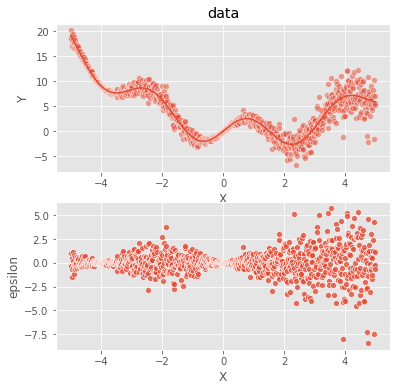

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(6,6))
sns.scatterplot(X, Y, alpha=0.5, ax=ax[0])
sns.lineplot(X, Y_, ax=ax[0])
ax[0].set_title('data')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
sns.scatterplot(X, noise, ax=ax[1], alpha=0.8)
ax[1].set_xlabel('X')
ax[1].set_ylabel('epsilon')

In [23]:
# insert outliers
def generate_data(n, rate=0.01, loc=[2,5], y=15):
    """
    n : number of data to generate
    rate : rate of outliers (set 0 if you don't want outlier)
    loc : mean location on x-axis for outliers 
    y : mean for outliers
    
    return 
    X : x-coordinate
    output : y-coordinate from noise less model
    Y : noisy output 
    """
    # base data
    X = npr.uniform(-5, 5, n)
    output = 1/2*X**2 + 3*np.sin(2*X)-X
    noise = npr.normal(0,1, len(X))*np.abs(np.abs(X+2)-2)/1.5
    Y = output+noise
    
    # generate outliers
    if not isinstance(loc, list):
        loc = [loc]
    out = int(n*rate/len(loc))
    Xout = []
    Yout = []
    for l in loc:
        out_data = npr.multivariate_normal([0,0], [[0.03,0],[0,0.5]], out)
        out_x = out_data[:, 0]+l
        out_y = out_data[:, 1]+y
        Xout.append(out_x)
        Yout.append(out_y)
    Xout = np.hstack(Xout)
    Yout = np.hstack(Yout)
    X = np.hstack([X, Xout])
    Y = np.hstack([Y, Yout])
    output = 1/2*X**2 + 3*np.sin(2*X)-X
    return X, output, Y

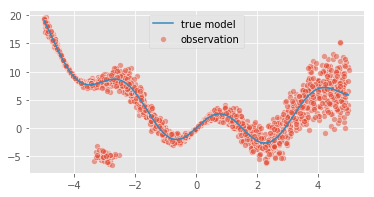

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
X, Y, Yobs = generate_data(2000, rate=0.02, loc=[-3], y=-5)
sns.scatterplot(X, Yobs, alpha=0.5, label='observation')
sns.lineplot(X, Y, color=palette[1], label='true model')
Yobs = scaler(Yobs)

# train Alpha and C

## 1 Optimizer

In [25]:
# TODO: random initialization?
# for example, you can use nn.Linear(1,1)
alpha = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
alpha = nn.Parameter(torch.Tensor(np.zeros([len(X)])))

scale = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
scale = nn.Parameter(torch.Tensor(np.zeros([len(X)])))

In [26]:
# try optimizing alternatively?
opt = torch.optim.Adam([alpha, scale], lr = 1e-4) 

x = torch.Tensor(X)
y = torch.Tensor(Yobs)

In [27]:
dist = distribution.Distribution()

In [28]:
# train 
for epoch in tqdm(range(15000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha), scale=torch.exp(scale), approximate=True))
    loss = loss + scale.mean() + dist.log_base_partition_function(torch.exp(alpha)).mean()
    opt.zero_grad() 
    loss.backward() 
    opt.step() 

    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=3.380486
1000: loss=3.134009
2000: loss=2.963596
3000: loss=2.834696
4000: loss=2.731860
5000: loss=2.646530
6000: loss=2.570144
7000: loss=2.507544
8000: loss=2.456092
9000: loss=2.412986
10000: loss=2.375963
11000: loss=2.343955
12000: loss=2.315890
13000: loss=2.291106
14000: loss=2.268854



Text(0.5, 0, 'X')

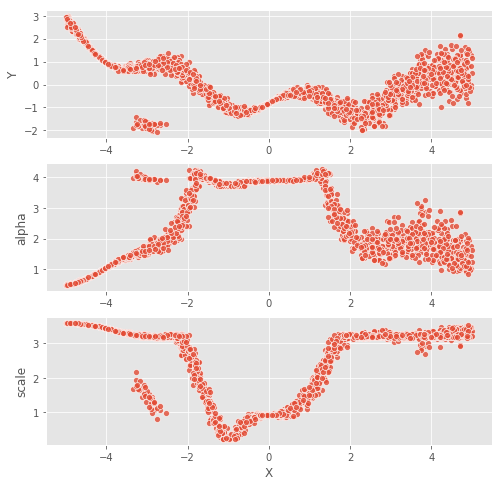

In [29]:
# plot result
alpha_np = torch.exp(alpha).data.numpy()
scale_np = torch.exp(scale).data.numpy()
fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, ax=ax[0], alpha=0.8)
sns.scatterplot(X, alpha_np, ax=ax[1], alpha=0.8)
sns.scatterplot(X, scale_np, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

# fit GPR on top of the alpha* and c* learned above

In [30]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [31]:
train_x = torch.Tensor(X)
train_a = torch.Tensor(alpha_np)
train_c = torch.Tensor(scale_np)

In [32]:
# Find optimal model hyperparameters
model = ExactGPModel(train_x, train_a, likelihood)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in tqdm(range(training_iter)):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_a)
    loss.backward()
    optimizer.step()

In [33]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(min(X), max(X), 51)
    observed_pred = likelihood(model(test_x))

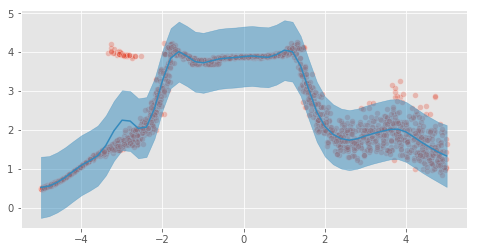

In [34]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    lower, upper = observed_pred.confidence_region()
    sns.scatterplot(train_x.numpy(), train_a.numpy(), ax=ax, alpha=0.3)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color=palette[1])
    sns.lineplot(test_x.numpy(), observed_pred.mean.numpy(), color=palette[1])

In [35]:
# Find optimal model hyperparameters
model = ExactGPModel(train_x, train_c, likelihood)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in tqdm(range(training_iter)):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_c)
    loss.backward()
    optimizer.step()

In [36]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(min(X), max(X), 51)
    observed_pred = likelihood(model(test_x))

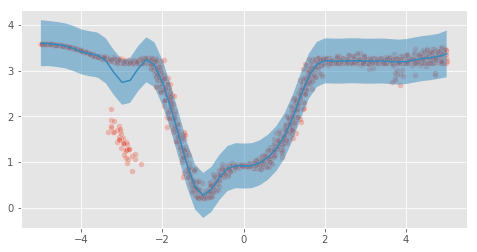

In [37]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    lower, upper = observed_pred.confidence_region()
    sns.scatterplot(train_x.numpy(), train_c.numpy(), ax=ax, alpha=0.3)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    sns.lineplot(test_x.numpy(), observed_pred.mean.numpy(), color=palette[1])